In [1]:
%matplotlib inline
import sys
import time
import random

from concurrent.futures import ProcessPoolExecutor

import numpy as np
import seaborn as sns
import pandas as pd
import xgboost as xgb
import cv2
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE

import features

from dataset import read_datasets, read_leap_motion_data
from features import extract_features, extract_lp_features, hog_single
from train import precision_for, train_clf, feature_precisions, predict_img
from utils import print_log, set_cache, get_cache, find_best_params, pca_accuracy

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Dataset Load
persons = read_leap_motion_data('LP_data/dataset', load_cache=True)

Trying fetch cache for persons
Using cache for persons
Time for >>read_leap_motion_data<<: 0.55 s


In [12]:
# Feature Extraction
X = []
y = []
X_limg = []
X_rimg = []
indices = []
for p in persons:
    print('Processing {}'.format(p))
    for g_idx in range(1, 11):
        for idx in range(1, 21):
            g = 'G{}'.format(g_idx)
            d = persons[p][g][idx]
            if not d:
                continue
            X_limg.append(hog_single(d['leye']))
            X_rimg.append(hog_single(d['reye']))
            f = extract_lp_features(d['json'])
            X.append(f)
            y.append(g_idx-1)
            indices.append((p, g, idx))
X = np.array(X)
y = np.array(y)

# Norm D and E
den = X[:, 7][:, None]
den[den == 0] = 1e9  # Infinity
X[:, 5:15] = X[:, 5:15] / den # dividing the values for the distance between the hand center and the middle fingertip S

# Norm T
den = np.max(X[:, 15:25], axis=1)[:, None]
den[den == 0] = 1e9
X[:, 15:25] = X[:, 15:25] / den

X[X < 1e-5] = 0

all_data = pd.DataFrame(np.append(X, y.reshape((-1, 1)), axis=1))
all_data.to_csv('caches/feature_set.csv', index=False, float_format='%.3f')
all_data

Processing P1
Processing P8
Processing P9
Processing P11
Processing P4
Processing P13
Processing P6
Processing P10
Processing P12
Processing P2
Processing P3
Processing P7
Processing P5


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [26]:
best_score = 0
best_prediction = None
best_y_test = None
k = 5
pca_var = 0.8

for i in range(20):
    print('Round :', i+1)
    X_train, X_test, X_limg_train, X_limg_test, X_rimg_train, X_rimg_test, y_train, y_test = train_test_split(
        X, X_limg, X_rimg, y, test_size=0.2)

    # Train Best clf for numerical data
    features_selection = features.F_A | features.F_D | features.F_T

    deletes = []
    if not (features_selection & features.F_T):
        deletes.extend(range(15, 25))
    if not (features_selection & features.F_E):
        deletes.extend(range(10, 15))
    if not (features_selection & features.F_D):
        deletes.extend(range(5, 10))
    if not (features_selection & features.F_A):
        deletes.extend(range(0, 5))       

    selected_X_train = np.delete(X_train, deletes, axis=1)

    selected_X_test = np.delete(X_test, deletes, axis=1)

    # Combine numerical data and pixel data
    Xnum_train = np.array(selected_X_train)
    Ximg_train = np.append(np.array(X_limg_train), np.array(X_rimg_train), axis=1)
    Xc_train_kx_hog = np.append(Xnum_train, k * Ximg_train, axis=1)

    Xnum_test = np.array(selected_X_test)
    Ximg_test = np.append(np.array(X_limg_test), np.array(X_rimg_test), axis=1)
    Xc_test = np.append(Xnum_test, Ximg_test, axis=1)
    Xc_test_kx_hog = np.append(Xnum_test, k * Ximg_test, axis=1)

    best_all_params = {'C': 10, 'gamma': 0.1}

    # Train set
    pca = PCA(pca_var)

    _train = Xc_train_kx_hog
    _train = pca.fit_transform(_train)

    _test = Xc_test_kx_hog
    _test = pca.transform(_test)

    all_clf = OneVsOneClassifier(SVC(**best_all_params), n_jobs=-1)
    all_clf.fit(_train, y_train)

    h_combine = all_clf.predict(_train).astype(int)
    h_combine_test = all_clf.predict(_test).astype(int)
    
    score = accuracy_score(h_combine_test, y_test)
    if score > best_score:
        best_score = score
        best_prediction_train = h_combine
        best_prediction_test = h_combine_test
        best_y_train = y_train
        best_y_test = y_test
        print('New best score:', best_score)

Round : 1
New best score: 0.980769230769
Round : 2
New best score: 0.986538461538
Round : 3
Round : 4
Round : 5
New best score: 0.990384615385
Round : 6
Round : 7
Round : 8
Round : 9
Round : 10
Round : 11
Round : 12
Round : 13
Round : 14
New best score: 0.994230769231
Round : 15
Round : 16
Round : 17
Round : 18
Round : 19
Round : 20



Combined features accuracy on train set : 100.00%
Combined features accuracy on test set  : 99.42%


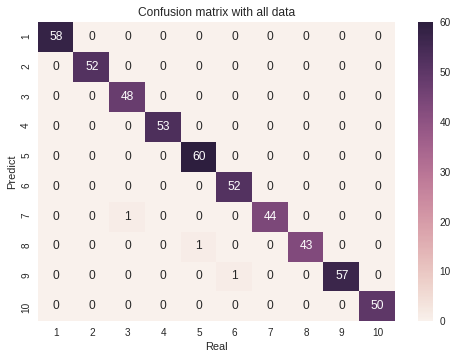

In [27]:
tot_confusion_mat = np.zeros((10, 10))
for i, j in zip(best_y_test, best_prediction_test):
    tot_confusion_mat[i][j] += 1
sns.heatmap(tot_confusion_mat, annot=True, xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Confusion matrix with all data')
print()
print('Combined features accuracy on train set : {:.2%}'.format(accuracy_score(best_prediction_train, best_y_train)))
print('Combined features accuracy on test set  : {:.2%}'.format(accuracy_score(best_prediction_test, best_y_test)))